In [ ]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping, Callback
from keras import optimizers
from keras.initializers import Orthogonal as orth

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio


nb_filters = 30
kernel_size = 40
dense1_n = 10
epochs = 1000

patience = 30

steps = np.arange(0.1, 0.6, 0.1)
reps = range(7)

acc = np.zeros((len(steps),len(reps)))

for j in range(len(steps)):
    for k in reps:
    
        print('Current test/train split is', steps[j], '/', 1-steps[j])
        print('Repetition', k, 'out of', max(reps))

        t0 = time.time()

        # load data from the .mat file:
        mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_ICA->0.5-38Hz,Env=1.mat')

        X = mat_contents['X']
        Y = mat_contents['Z'].T

        winsize = mat_contents['winsize']
        stepsize = mat_contents['stepsize']
        trial_len = mat_contents['trial_len']
        low_cutoff = mat_contents['low_cutoff']
        high_cutoff = mat_contents['high_cutoff']
        source = mat_contents['filein']

        # verify that the model REALLY finds a mapping between the input and the labels. If we get
        # our accuracy by chance, then we should get the same accuracy on a permuted dataset:
        # Y = np.random.permutation(Y)

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=steps[j])
        print('Original data type:', x_train.dtype)

        # convert to float64 for numerical stability:
        x_train = x_train.astype('float64')
        y_train = y_train.astype('float64')
        x_test = x_test.astype('float64')
        y_test = y_test.astype('float64')

        # normalize to unit variance and zero mean:
        for i in range(x_train.shape[0]):
            x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
            x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)

        for i in range(x_test.shape[0]):
            x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
            x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)

        # ensure the tensors are sized right:
        x_train = np.transpose(x_train,(0,2,1))
        x_test = np.transpose(x_test,(0,2,1))

        # one hot encode the labels:
        onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
        y_train = onehot_encoder.fit_transform(y_train)
        y_test = onehot_encoder.fit_transform(y_test)

        # convert to float16 to save space:
        x_train = x_train.astype('float16')
        y_train = y_train.astype('float16')
        x_test = x_test.astype('float16')
        y_test = y_test.astype('float16')
        print('Normalized data type:', x_train.dtype)

        print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
        print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

        print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
        print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

        print('Window length', winsize)
        print('Step size:', stepsize)
        print('Length of trial during experiment', trial_len)
        print('Low cutoff freq.', low_cutoff)
        print('High cutoff freq.', high_cutoff)
        print('Source data file:', source)

        leng = x_test.shape[1]

        def Encoder():

            input_img = Input(shape=(leng, 60))
            inputbn = BatchNormalization(axis = 1)(input_img) ###########################################why this axis?

            convolved = Conv1D(nb_filters, kernel_size, padding="same", activation='relu',
                              kernel_initializer = orth(gain=1.0, seed=None))(inputbn)
            dropout1 = Dropout(0.1)(convolved)
            convolvedbn = BatchNormalization()(dropout1)
            pooled = MaxPooling1D()(convolvedbn)

            convolved2 = Conv1D(nb_filters*2, kernel_size, padding="same", activation='relu',
                               kernel_initializer = orth(gain=1.0, seed=None))(pooled)
            dropout2 = Dropout(0.2)(convolved2)
            convolved2bn = BatchNormalization()(dropout2)
            pooled2 = MaxPooling1D()(convolved2bn)

            convolved3 = Conv1D(nb_filters*4, kernel_size, padding="same", activation='relu',
                               kernel_initializer = orth(gain=1.0, seed=None))(pooled2)
            dropout3 = Dropout(0.3)(convolved3)
            convolved3bn = BatchNormalization()(dropout3)
            pooled3 = MaxPooling1D()(convolved3bn)

            flat = Flatten()(pooled3)

            dense1 = Dense(dense1_n, activation='relu')(flat)
            dense1bn = BatchNormalization()(dense1)
            dense1do = Dropout(0.5)(dense1bn)

            out = Dense(2, activation='softmax')(dense1do)

            return Model(input_img, out)


        enc = Encoder()
        enc.compile(loss="binary_crossentropy", optimizer="adadelta", metrics=["accuracy"])

        # enc.summary()
        ##########################################################

        # Training time!
        from keras.callbacks import TensorBoard, EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

        train_history = enc.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=40,
                        shuffle=True,
                        validation_data=(x_test, y_test),
                        callbacks=[TensorBoard(log_dir='/home/amplifier/home/CNN_stim'), early_stopping])

        ###########################################################

        # let's predict a TRAINING sammple:
        decoded_train = enc.predict(x_train)
        decoded_test = enc.predict(x_test)
        #####################################################

        # now test sample by sample
        cor_test = []
        L = x_test.shape
        for sample_no in range(x_test.shape[0]):
            pred = enc.predict(np.expand_dims(x_test[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_test[sample_no,0] < y_test[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) & (y_test[sample_no,0] > y_test[sample_no,1]))):
                cor_test.append(1)
            else:
                cor_test.append(0)

        cor_train = []
        L = x_train.shape
        for sample_no in range(x_train.shape[0]):
            pred = enc.predict(np.expand_dims(x_train[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_train[sample_no,0] < y_train[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) & (y_train[sample_no,0] > y_train[sample_no,1]))):
                cor_train.append(1)
            else:
                cor_train.append(0)

        # Report accuracies
#         print('Accuracy on the test data:', np.mean(cor_test))
#         print('Accuracy on the training data:', np.mean(cor_train))
        t1 = time.time()
        print('Elapsed', t1-t0, 'seconds')

        acc[j,k] = np.mean(cor_test)

In [41]:
acc

array([[ 0.80246914,  0.7654321 ,  0.86419753,  0.87654321,  0.81481481,
         0.79012346,  0.81481481],
       [ 0.75308642,  0.82098765,  0.7962963 ,  0.80864198,  0.85802469,
         0.77160494,  0.69135802],
       [ 0.80991736,  0.77272727,  0.7768595 ,  0.72727273,  0.7107438 ,
         0.69834711,  0.71900826],
       [ 0.58204334,  0.62848297,  0.62229102,  0.6130031 ,  0.61919505,
         0.6873065 ,  0.62229102],
       [ 0.64019851,  0.62531017,  0.61538462,  0.68238213,  0.63275434,
         0.61538462,  0.61042184],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

Text(0,0.5,'Percent Accuracy')

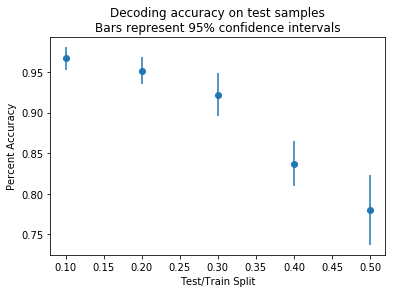

In [6]:
x = steps
y = np.mean(acc[0:len(steps)],1)
yerr = 1.96*np.std(acc[0:len(steps),:], axis=1)/np.sqrt(len(steps))
plt.errorbar(x, y, yerr=yerr, fmt='o')
plt.title('Decoding accuracy on test samples' + '\n' + 'Bars represent 95% confidence intervals')
plt.xlabel('Test/Train Split')
plt.ylabel('Percent Accuracy')